# Welcome to our simple sea ice model

Zu diesem Jupyter Notebook: Code führt ihr aus indem ihr auf eine code Zelle klickt und anschließend auf den Pfeil (run) oben. Das führt nur diese eine Zelle aus! Unter Run/Run All Cells könnt ihr das ganze Notebook ausführen (empfohlen). Unter den Code-Zellen werden dann die Ergebnisse, (z.b. Abbildungen) oder Fehlermeldungen angezeigt. Ihr könnt alles verändern und damit auch leicht Fehler in den code einbauen. Das wird passieren und ist beabsichtigt, programmieren besteht gefühlt zu 90% daraus Fehler zu finden und zu korrigieren. Lasst euch nicht ärgern. Um Änderungen rückgängig machen zu können, denkt daran zu speichern immer wenn etwas funktioniert, sodass ihr mit File/Revert Notebook to Checkpoint diese wiederherstellen könnt. Falls gar nichts mehr geht könnt ihr den originalen Link neu öffnen und kommt wieder zu der ursprünglichen Version.

Wir verwenden die Wärmebilanz an der Oberfläche und Unterseite des Eises um Veränderungen (insbesondere der Eisdicke) zu bestimmen. Das bedeutet, dass wir vor allem die kurzwellige Sonneneinstrahlung (short wave radiation) und langwellige thermische Strahlung (long wave radiation) sowie die den Wärmefluss an der Unterseite (ocean heat flux) 'kennen' müssen. Außerdem schreiben wir vor wie viel Schnee über das Jahr hinweg fällt. Das Eis und der Schnee werden jeweils als eine homogene Schicht dargestellt (wie auf der linken Seite der folgenden Abbildung), sodass sich die Temperatur mit der tiefe durch zwei gerade Linien beschreiben lässt.

![](https://www.researchgate.net/publication/319631226/figure/fig1/AS:537617779642368@1505189475441/Schematic-demonstrating-the-evolution-of-a-the-old-zero-layer-ice-thermodynamics_W640.jpg)

Falls ihr Text in diesem Notebook schreiben wollt gehört der entweder in Zellen die als 'Markdown' markiert sind (wie diese) oder bei kurzen Kommentaren zum code in einer Zeile die mit einem Hash beginnt (siehe folgende Zelle).

Lasst uns mit dem Programm beginnen. Zunächst gibt es ein paar Informationen zu dem Programm, gefolgt vom Einbinden von zwei Modulen um mehr Befehle zur Verfügung zu haben. Interessanter sind die Funktionen die anschließend definiert (def ...) werden. Habt ihr eine Idee wofür diese Funktionen genutzt werden? Tipp: doy steht für 'Day of Year'

In [90]:
##########################################################################
# This program implements a more advanced version of the zero-layer model.
# It carries out the following steps:
# 1. Calculate surface temperature T_surf from heat-flux balance
# 2. If T_surf > 273 K, set T_surf to 273 K and calculate surface melting
# 3. Calculate heat flux in ice assuming a linear temperature profile
# 4. Calculate change in ice thickness from energy balance and ice bottom
# 5. Calculate new ice thickness
#
# Based on AGF 211 exercise, part 3.1
#
# Written by Dirk Notz
#
# 07 February 2013
#
#########################################################################

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt



def snowfall(doy):
    if doy>232 and doy <=304:       
        SF = 0.30/72
    elif doy > 304 or doy < 122:
        SF = 0.05/176
    elif doy >=122 and doy < 154:
        SF = 0.05/31
    else:
        SF = 0
    #SF=0
    return SF 

def otherfluxes(doy):
    LWave = 118. * np.exp(-0.5 * (doy-206.)**2 / (53.**2)) + 145.
    return LWave#+17. #+5.2
  
#def shortwave(doy, lat):
#    SW  = 314 * np.exp(-(doy-164.)**2/4608.)
#    return SW

def shortwave(day, lat):
    swAA=np.sin(day/365*np.pi)**6*np.sin(lat/180.*np.pi)**4
    if lat<0: swAA=0.
    sw=np.cos((lat-30.*np.sin(day/365*np.pi)**2+15.)/360.*2*np.pi)**2 +0.7* swAA
    sw=sw*275.
    return sw

def albedo(doy):
    alpha=-0.431/(1+((doy-207.)/44.5)**2)+0.914
    return alpha


Diese Funktionen werden weiter unten nützlich, doch zuerst definieren ein paar variablen die wir nach Gutdünken gesetzt haben und ihr auch gerne verändern könnt:

In [91]:
Q_ocean   = 5.                # Heat flux from the water
h_ice1    = 0.5               # Initial ice thickness
days_total= 3650              # Number of days we run the model

Als nächstes kommen ein paar Konstanten und das eigentliche Modell. Hier müsst ihr nichts verändern (aber dürft wenn ihr euch traut). Das Modell rechnet (unter anderem) die Schnee und Eisdicke für den gesamten Zeitraum aus. Wie ihr seht ist das Modell auch als Funktion geschrieben (def ...), es wird also zuerst einmal nur definiert und kann anschließend aufgerufen werden (wie in der folgenden Zelle geschehen).

In [92]:
#Code in this box does not need to be changed!

albedow   = 0.1               # albedo of the water
eps_sigma = 0.95*5.67e-8      # Constant in Boltzman-law
L         = 334000.           # Latent heat of freezing for water [J/kg]
c_w       = 4000.             # Heat capacity of water
depth     = 50.               # Depth of the mixed layer
rho_w     = 1025.             # Density of sea water
rho_i     = 970.              # density of ice [kg/m^3]
rho_s     = 330.              # density of snow [kg/m^3]
k_ice     = 2.2               # heat conductivity of ice [W/(m K)]
k_snow    = 0.3               # heat conductivity of snow [W/(m K)]
Tbot      = -1.8+273.15       # Ice bottom temperature in Kelvin
dt        = 86400.            # Time step in seconds

def seaice_model(lat=70.):
    T_water=np.zeros(days_total)+Tbot
    h_snow=np.zeros(days_total)
    h_ice=np.zeros(days_total)
    Tsurf=np.zeros(days_total)
    h_ice[0]=h_ice1


    for day in range(days_total-1):
        doy=day%365
        if doy==0: doy=365

        if h_ice[day] > 0:
            Q_surf_in = (1-albedo(doy))*shortwave(doy, lat) + otherfluxes(doy)

            # Calculate surface temperature
            a = eps_sigma
            b = 0.
            c = 0.
            d = 1./(h_ice[day]/k_ice+h_snow[day]/k_snow)
            e = - Q_surf_in  - Tbot/(h_ice[day]/k_ice+h_snow[day]/k_snow)
            Tsurf[day]= np.max(np.real(np.roots([a,b,c,d,e])))

            if Tsurf[day] > 273.15: 
                Tsurf[day]   = 273.15

            # Heat flux in the ice
            Q_ice       = - (Tsurf[day] - Tbot) / (h_ice[day]/k_ice + h_snow[day]/k_snow)

            # Outgoing longwave heat flux
            Q_surf_out  = eps_sigma * Tsurf[day]**4

            # Calculate heat flux imbalance at surface. 
            # This is zero as long as Tsurf < 273.15
            Q_surf      = Q_surf_out - Q_surf_in - Q_ice

            # Calculate thickness change at bottom
            delta_h_bot = (Q_ice-Q_ocean) * dt /  (rho_i * L)          

            # Calculate thickness change at surface
            if h_snow[day] > 0:
              delta_h_snow = Q_surf *dt /  (rho_s * L)
              delta_h_surf = 0
            else:
              delta_h_surf = Q_surf *dt /  (rho_i * L)                    
              delta_h_snow = 0

            # Calculate new ice thickness
            h_ice[day+1]     = h_ice[day] + delta_h_surf + delta_h_bot           

            # Calculate new snow thickness
            h_snow[day+1] = h_snow[day] + snowfall(doy) + delta_h_snow

            # If more snow melted than we had, melt some ice
            if h_snow[day+1] < 0:
                h_ice[day+1]=h_ice[day+1]+h_snow[day+1]*rho_s/rho_i
                h_snow[day+1] = 0

            T_water[day+1]=Tbot

        else:   # If there is no more ice

            # Set surface temperature to water temperature
            Tsurf[day] = T_water[day]  

            # Calculate heat flux at sea surface
            Q_surf = -((1 - albedow) * shortwave(doy, lat) + otherfluxes(doy)) + eps_sigma * T_water[day]**4

            # Change water temperature accordingly
            T_water[day+1] = T_water[day] - Q_surf / (rho_w*c_w * depth) * dt

            # Change water temperatute for the few cases where h_ice <0, otherwise
            # nothing happens here since h_ice is usually 0
            T_water[day+1] = T_water[day+1] - h_ice[day] * rho_i * L / (rho_w * c_w * depth)

            # Set h_ice to 0
            h_ice[day] = 0

            # If water starts freezing, set temperature to freezing temperature
            # and use excess heat to form some ice
            if T_water[day+1] < Tbot:
                h_ice[day+1] = -(T_water[day+1] - Tbot) * rho_w * c_w * depth / (rho_i * L)
                T_water[day+1] = Tbot
                h_snow[day+1] = 0
            else:
                h_ice[day+1] = 0
                h_snow[day+1] = 0
                
                
    return Tsurf, h_ice, h_snow, T_water



In [93]:
Tsurf, h_ice, h_snow, T_water = seaice_model()

Die Ergebnisse sind in den vier variablen links von dem gleich gespeichert, jetzt müssen wir sie noch darstellen. Ich eine im Folgenden eine Abbildung der Ergebnisse vorprogrammiert ('geplottet'). Wer möchte kann sich die Werte von variablen auch mit dem Befehl print() anzeigen lassen (z.B. in der leeren Zelle unter dieser). Dabei muss in den Klammern die Variable stehen die euch interessiert. Falls ihr es probiert: was ist der große Nachteil dieser Art der Ausgabe?

Nur print() zu benutzen bringt wirklich keinen Spaß, daher hier ein paar Plots: 

Text(0, 0.5, 'Water temperature [°C]')

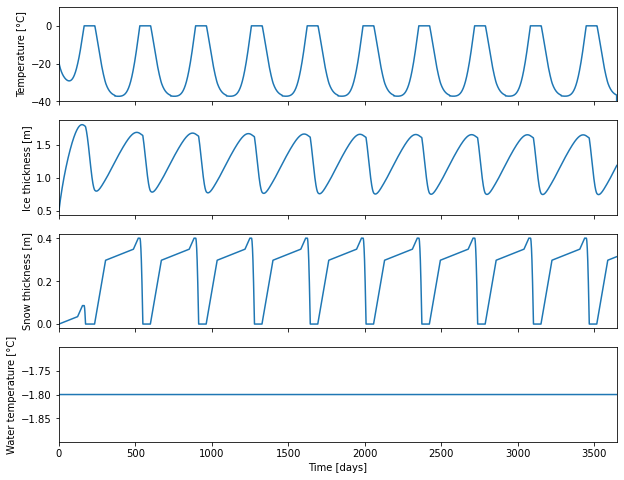

In [94]:
# Plot temperature evolution
fig, axes=plt.subplots(nrows=4, sharex=True, figsize=(10, 8))
ax=axes[0]
ax.plot(Tsurf-273.15)
ax.set_xlim([0, days_total])
ax.set_ylim([-40,10])
#ax.set_xlabel('day')
ax.set_ylabel('Temperature [°C]')

# Plot ice-thickness evolution
ax=axes[1]
ax.plot(h_ice)
ax.set_xlim([0, days_total])
#ax.set_xlabel('day')
ax.set_ylabel('Ice thickness [m]')
  
# Plot snow-thickness evolution
ax=axes[2]
ax.plot(h_snow)
ax.set_xlim([0, days_total])
#ax.set_xlabel('day')
ax.set_ylabel('Snow thickness [m]')
  
# Plot water temperature
ax=axes[3]
ax.plot(T_water-273.15)
ax.set_xlim([0, days_total])
ax.set_xlabel('Time [days]')
ax.set_ylabel('Water temperature [°C]')



#### Ein paar Erklärungen zu den Variablen:

-Die Temperatur (ganz oben) ist die Oberflächentemperatur des Eises/Schnees/...

-Die Wassertemperatur ist die Temperatur des Wassers im direkten Kontakt mit der Unterseite des Eises (falls vorhanden).

#### Gemeinsam:
-Woher kommt das Zickzack Muster?


#### Mögliche Frage die ihr untersuchen könnt:

-Vergleiche die Oberflächentemperatur mit dem typischen Temperaturen am Nordpol (google), Stimmen diese in etwa überein? Versuche den größten Unterschied zu erklären.

-Wieso ist die Wassertemperatur meistens bei -1.8°C und nicht bei 0°C?

-Wie große ist der Einfluss von dem anfänglichen Eisdicke auf die Eisdicke nach 10 Jahren? Wieso könnten solche Fragen wichtig für Klimaforscher sein?

-Was ist der Einfluss von Schnee auf dem Eis? Was passiert falls in Zukunft doppelt/halb so viel Schnee fällt?

-Wie groß ist der Einfluss von dem Ozean-Wärmefluss auf das Eis? Was passiert falls in Zukunft doppelt/drei mal so viel Wärme von dem Ozean bereitgestellt wird?

-Gegebenenfalls: Was passiert manchmal (z.B am Anfang) mit der Wassertemperatur? Welchen Einfluss hat diese Besonderheit auf das Eis im folgendem Winter?




# Breiten abhöngigkeit der Eisdicke

Bisher haben wir Eis an einem einzigen Ort simuliert, das könnte etwa eine Messtation an der Sibirischen Küste oder am Nordkap sein. Für ein echtes 2D Eismodell der Arktis müssten wir insbesondere die Drift von dem Eis berücksichtigen die großen Einfluss auf die Verteilung und das überleben vom Eis hat. Das können wir hier nicht leisten. Als ersten kleinen Schritt in Richtung eines 2D Modells können wir allerdings versuchen die Breitengrasabhängigkeit der Strahlung zu imitieren. Bisher haben wir die nördliche breite (Latitude, kurz:lat) nicht spezifiziert wenn wir das Eismodell aufgerufen haben (in der Zeile: Tsurf, h_ice, h_snow, T_water = seaice_model()). In diesem Fall greift die Definition der Funktion auf lat=70. also 70° N, zurück. Jetzt werden wir die gleichen Zeitreihen (10 Jahre) für viel Breitengrade berechnen und anschließend auf einer Karte darstellen:

In [95]:
lats=np.linspace(40, 90, 51)
Tsurf_dayslats=np.zeros([days_total, len(lats)])
h_ice_dayslats=np.zeros([days_total, len(lats)])
h_snow_dayslats=np.zeros([days_total, len(lats)])
T_water_dayslats=np.zeros([days_total, len(lats)])

for i in range(len(lats)):
    Tsurf_dayslats[:,i], h_ice_dayslats[:,i], h_snow_dayslats[:,i], T_water_dayslats[:,i] = seaice_model(lats[i])

In der *for* schleife wird eine Zeitreihe für jeden Breitengrad zwischen 40°N und 90°N berechnet. Manchmal ist das darstellen mehr Arbeit als das Berechnen der Daten selbst:

/home/dusch/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


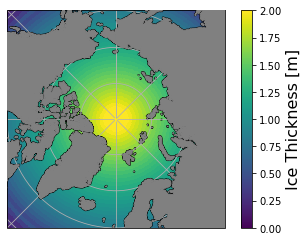

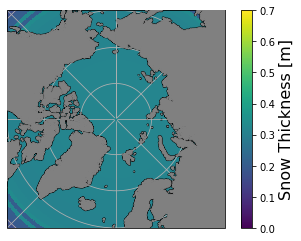

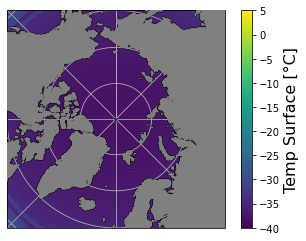

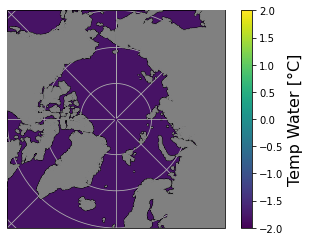

In [96]:
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

#Which day to plot?
day_to_plot=3286



#Regridding to a 2d  map centered at the North Pole
ref_crs=ccrs.NorthPolarStereo()

lon_map=(np.ones([360,len(lats)]).T*np.linspace(0,359, 360)).T
lat_map=np.ones([360,len(lats)])*lats

xyz_cci = ref_crs.transform_points(ccrs.PlateCarree(), lon_map, lat_map)
x_map=xyz_cci[:,:,0]
y_map=xyz_cci[:,:,1]


#this is the plotting itself (once for each variable):
if 1:        
    plt.figure()
    ax = plt.axes(projection = ref_crs)  # create a set of axes with Mercator projection
    pcol=ax.pcolormesh(x_map, y_map, np.ones([360,len(lats)]) * h_ice_dayslats[day_to_plot,:], vmin=0, vmax=2.)
    cbar=plt.colorbar(pcol)
    cbar.set_label('Ice Thickness [m]',size=16)
    ax.add_feature(cf.LAND, color='gray', zorder=100)
    #ax.add_feature(cf.COASTLINE, color='lightgray')
    ax.gridlines(xlocs=np.linspace(-180, 180, 9), ylocs=np.linspace(0, 80, 9))
    ax.coastlines(linewidth=2)
    ax.set_xlim([-3.42e6, 3.42e6])
    ax.set_ylim([-3.42e6, 3.42e6])

    plt.figure()
    ax = plt.axes(projection = ref_crs)  # create a set of axes with Mercator projection
    pcol=ax.pcolormesh(x_map, y_map, np.ones([360,len(lats)]) * h_snow_dayslats[day_to_plot,:], vmin=0, vmax=0.7)
    cbar=plt.colorbar(pcol)
    cbar.set_label('Snow Thickness [m]',size=16)
    ax.add_feature(cf.LAND, color='gray', zorder=100)
    #ax.add_feature(cf.COASTLINE, color='lightgray')
    ax.gridlines(xlocs=np.linspace(-180, 180, 9), ylocs=np.linspace(0, 80, 9))
    ax.coastlines(linewidth=2)
    ax.set_xlim([-3.42e6, 3.42e6])
    ax.set_ylim([-3.42e6, 3.42e6])

    plt.figure()
    ax = plt.axes(projection = ref_crs)  # create a set of axes with Mercator projection
    pcol=ax.pcolormesh(x_map, y_map, np.ones([360,len(lats)]) * Tsurf_dayslats[day_to_plot,:]-273.15, vmin=-40, vmax=5.)
    cbar=plt.colorbar(pcol)
    cbar.set_label('Temp Surface [°C]',size=16)
    ax.add_feature(cf.LAND, color='gray', zorder=100)
    #ax.add_feature(cf.COASTLINE, color='lightgray')
    ax.gridlines(xlocs=np.linspace(-180, 180, 9), ylocs=np.linspace(0, 80, 9))
    ax.coastlines(linewidth=2)
    ax.set_xlim([-3.42e6, 3.42e6])
    ax.set_ylim([-3.42e6, 3.42e6])

                                                                            
    plt.figure()
    ax = plt.axes(projection = ref_crs)  # create a set of axes with Mercator projection
    pcol=ax.pcolormesh(x_map, y_map, np.ones([360,len(lats)]) * T_water_dayslats[day_to_plot,:]-273.15, vmin=-2., vmax=2.)
    cbar=plt.colorbar(pcol)
    cbar.set_label('Temp Water [°C]',size=16)
    ax.add_feature(cf.LAND, color='gray', zorder=100)
    #ax.add_feature(cf.COASTLINE, color='lightgray')
    ax.gridlines(xlocs=np.linspace(-180, 180, 9), ylocs=np.linspace(0, 80, 9))
    ax.coastlines(linewidth=2)
    ax.set_xlim([-3.42e6, 3.42e6])
    ax.set_ylim([-3.42e6, 3.42e6])
    #ax.text(-3.2e6, 3.1e6, '2019-03-15', fontsize=13, c='w')

Die Abbildung oben zeigt die Eisdicke nach day_to_plot=3286 tagen (hier hat ein Jahr genau 365 Tage, 9 Jahre= 3285 tage, Tag 3286 ist demnach ein 1. Januar).

Wann im Jahr Erwartet ihr, dass es am wenigsten Eis gibt? Stimmen eure Erwartungen mit dem Modell überein? Hierfür könnt ihr gerne annehmen dass alle Monate genau 30 Tage haben. Ihr könnt die Ergebnisse für Mitte September auch mit Satellitendaten vom sea-ice portal des Alfred Wegener Instituts vergleichen (Link unter: https://www.awi.de/en/focus/sea-ice.html).

Tip: Es ist vermutlich sinnvoll die Änderungen von den letzten Aufgaben zuerst zurück zu drehen um ein Frage nach der Anderen zu beantworten. Wenn ihr dann noch Lust habt könnt ihr auch verschiedene Aspekte kombinieren (z.b. 2° wärmeres Klima mit reduziertem Schnee)

#### Climate change

Ohne Climate Action schlittern wir global auf bis zu 8.5W/m^2 zusätzlicher **longwave radiation** bis zum Jahre 2100 zu. In optimistischeren Szenarios (in etwa entsprechend 2° globaler Erwärmung) sind es nur 2.6W/m^2. In der Arktis ist die Erwärmung deutlich höher (ca. doppelt so groß). Was verändert sich wenn ihr die longwave radiation entsprechend erhöht (Tip: die Funktion die ihr sucht ist in der ersten code Zelle)? Denkt daran Run/Run all zu benutzen nachdem ihr Funktionen verändert, sonst wird nicht die aktualisierte Version verwendet.

Wenn die Menschen ihr Verhalten nicht ändern, wird es dann in diesem Jahrhundert einen eisfreien Arktischen Ozean geben? In anderen Worten, findet ihr einen Tag an dem die Eisdicke überall 0 (oder sehr dicht an 0) ist? Wie sieht es bei geringerer Erderwärmung aus?

#### Disclaimer
For educational purposes only. Alle berechneten Werte sind falsch, aber ich hoffe sie sind nützlich.

# Extra Aufgabe (Kontolle der Parameterisierung):

Hatzianastassiou und andere haben in einem wiss. Artikel (https://acp.copernicus.org/articles/5/2847/2005/acp-5-2847-2005.pdf) die Sonneneinstrahlung nahe der Erdoberfläche simuliert und mit Messdaten kombiniert. In Abbildung 3a (siehe unten) ist die Strahlungsstärke Abhängig von der Breite (Latitude) und den Jahreszeiten dargestellt. Um keine externen Daten einlesen zu müssen habe ich versucht eine Funktion zu basteln die ausreichend ähnliche Ergebnisse liefert (quick and diry). Dieser Vorgang wird Parametrisierung genannt wobei ein komplexer Prozess durch eine einfache Gleichung ersetzt wird. Meist wird dies gemacht weil der ursprüngliche Prozess für eine Anwendung nicht modelliert werden kann (oder soll) aber die wesentlichen Auswirkungen nicht ignoriert werden können.

Vergleicht die Abbildung aus der Literatur mit dem Plot den die folgende Zelle generiert und entscheidet ob diese ausreichend gut übereinstimmen. Dazu müsst ihr jedoch erstmal die Funktion für die kurzwellige Strahlung für viele mögliche Kombinationen von Breitengraden und Tagen-des-Jahres auswerten. Wer noch nicht genug hat kann die Parametrisierung auch verbessern.

In [97]:

#find/check parameterisation of fig 3a in https://acp.copernicus.org/articles/5/2847/2005/acp-5-2847-2005.pdf
#plt.figure()
lats=np.linspace(-90,90, 100)
doys=np.arange(365)
lats2d, doys2d=np.meshgrid(lats, doys)
sw2d=np.zeros_like(doys2d)

for i in range(len(doys)):
    for j in range(len(lats)):
        sw2d[i,j] =     #???
        '''         ^^^      bereche die short wave radiation für das Element i,j von doys2d und lats2d hier '''
        #Tipp: Das Element einer matrix A in i-ten reihe und der j-ten spalte kann mit  A[i,j] abgerufen werden
    
plt.figure()
plt.contourf(doys2d,lats2d, sw2d)
plt.colorbar()
    

SyntaxError: invalid syntax (<ipython-input-97-15eb39170ca6>, line 10)

![](https://raw.githubusercontent.com/duschlamp/zerolayerSI/main/sw_lit.png)

Hatzianastassiou, N., Matsoukas, C., Fotiadi, A., Pavlakis, K. G., Drakakis, E., Hatzidimitriou, D., & Vardavas, I. (2005). Global distribution of Earth's surface shortwave radiation budget. Atmospheric Chemistry and Physics, 5(10), 2847-2867.